## Making a detection efficiency heatmap

This notebook allows you to import lists of fit periods and radii and true periods and radii for simulated planets and create a detection efficienty heatmap.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm

plt.rcParams['figure.dpi'] = 150

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_pickle("found_data.pkl")
df_true = pd.read_pickle("true_data.pkl")

df_true["Exo_Detection"] = np.nan
df_true["Found_Period"] = np.nan
df_true["Period_Error"] = np.nan
df_true["Found_Amp"] = np.nan
df_true["Amp_Error"] = np.nan

for index, row in df_true.iterrows():
    star = df_true.iloc[index]['Star']
    period = df_true.iloc[index]['True_Period']
    exostriker = df.loc[df['Star'] == star]
    for i in range(0, len(exostriker)):
        found_per = exostriker.iloc[i]['Found_Period']
        if found_per < period*1.05 and found_per > period*0.95:
            df_true.at[index, "Exo_Detection"] = 1 #found
            df_true.at[index, "Found_Period"] = exostriker.iloc[i]['Found_Period']
            df_true.at[index, "Period_Error"] = exostriker.iloc[i]['Period_Error']
            df_true.at[index, "Found_Amp"] = exostriker.iloc[i]['Found_Amp']
            df_true.at[index, "Amp_Error"] = exostriker.iloc[i]['Amp_Error']
df_true = df_true[df_true['Total_Planet'] > 4]

In [3]:
# Creating some fake data
# To run this code, you need to have 4 arrays: 
# One with the "true" periods, one with the "true" radii, one with "fit" periods and one with "fit" radii

nplanets = len(df_true)
#nwrong = 100

# I'm picking 100 random planets to have wrong fit periods and radii
#unrec_indices = range(nwrong)

true_periods = list(df_true['True_Period'])
fit_periods = list(df_true['Found_Period'])

#true_periods = np.random.uniform(low=0.0, high=300.0, size=nplanets)
#wrong_periods = true_periods[unrec_indices] + np.random.uniform(low=20.0, high=50.0, size=len(unrec_indices))
#fit_periods = np.concatenate((wrong_periods, true_periods[nwrong:]))

true_rprs = list(df_true['Planet_Mass'])
#true_rprs = np.random.uniform(low=0.05, high=0.85, size=nplanets)
#wrong_rprs = true_rprs[unrec_indices] + np.random.uniform(low=20.0, high=50.0, size=len(unrec_indices))
#fit_rprs = np.concatenate((wrong_rprs, true_rprs[nwrong:]))


In [28]:
# true_periods = [5, 5]
# true_rprs = [0.5, 0.5]

# fit_periods = [5, 25]
# fit_rprs = [0.5, 0.9]


In [4]:
def heatmap_bins(period_min, period_max, nperbins, rprs_min, rprs_max, nradbins, logper=True, base='e'):
    """
    Gets bin edges for detection efficiency heatmap.
    
    Parameters
    ----------
    period_min: float
        Minimum period in sample
    period_max: float
        Maximum period in sample
    nperbins: int
        Number of period bins in heatmap
    rprs_min: float
        Minimum Rp/Rs in sample (or radius)
    rprs_max: float
        Maximum Rp/Rs in sample (or radius)
    nradbins: int
        Number of radius bins in heatmap
    logper: boolean, default True
        Log x (period)-axis?

    Returns
    -------
    per_segments: np.array
        Array of x-axis (period) bin edges
    rprs_segments: np.array
        Array of y-axis (radius) bin edges
    
    """

    if logper==True:

        if base=='10':
            
            natural_val = np.linspace(period_min, np.log10(period_max), num=nperbins, endpoint=True).round(decimals=2)
            per_segments = np.array([10**x for x in natural_val]).round(decimals=2)
        
        elif base=='e':

            natural_val = np.linspace(period_min, np.log(period_max), num=nperbins, endpoint=True).round(decimals=2)
            per_segments = np.array([np.e**x for x in natural_val]).round(decimals=2)
        
        else:
            
            print('Base not supported')
            return
        
    elif logper==False:
        
        per_segments = np.linspace(period_min, period_max, num=nperbins, endpoint=True).round(decimals=2)

    
    rprs_segments = np.linspace(rprs_min, rprs_max, num=nradbins).round(decimals=2)
    
    return per_segments, rprs_segments


In [5]:
# Getting bin edges

# In heatmap_bins, the arguments are: minimum period, maximum period, # of x-axis bins you want, minimum Rp/Rs, maximum Rp/Rs, and # of y-axis bins you want.


per_segments, rprs_segments = heatmap_bins(0.0, 300.0, 20, 0.05, 0.85, 20, logper=True, base='e')

In [9]:
def is_recovered(period, fitper, rprs, fitrprs, per_segments, rprs_segments):#true (injected) period, L-M fitting period, true rp/rs, L-M fitting rp/rs
    
    """
    Determines whether a planet is recovered.
    
    ** Note **
    The first if-statement can be changed to reflect the conditions for planet recovery.
    
    ** Note **
    r_list, recovered_period, and recovered_rprs must be defined outside of this function (see cell below)
    
    
    Parameters
    ----------
    period: float
        True (known) period of simulated planet
    fitper: float
        Fit (recovered) period of simulated planet
    rprs: float
        True (known) Rp/Rs of simulated planet
    fitrprs: float
        Fit (recovered) Rp/Rs of simulated planet
    per_segments: np.array
        Period bin edges
    rprs_segments: np.array
        Radius bin edges
        
    Returns
    -------
    None
    
    
    """
    
    if abs(fitper-period) < .05*period:
    #You can define your own definition of "recovered" here.
    
        recovered = True
        
        recovered_period.append(period)
        recovered_rprs.append(rprs)
        
        for p_i in range(len(per_segments)-1):
            for r_i in range(len(rprs_segments)-1):
                if per_segments[p_i] < period < per_segments[p_i+1]:
                    if rprs_segments[r_i] < rprs < rprs_segments[r_i+1]:
                        r_list[r_i][p_i] += 1
                        
    else:
        
        recovered = False


In [10]:
# Define lists to save for heatmap
r_list = np.zeros((len(per_segments), len(rprs_segments)))
recovered_period = []
recovered_rprs = []


for i in tqdm(range(nplanets)):
    is_recovered(true_periods[i], fit_periods[i], true_rprs[i], per_segments, rprs_segments)

  0%|          | 0/4027 [00:00<?, ?it/s]


TypeError: is_recovered() missing 1 required positional argument: 'rprs_segments'

In [45]:
def plot(recovered_period, recovered_rprs, true_periods, true_rprs, filename='heatmap.png', xlog=True, logxlabels=True, base='e'):
    
    """
    Plots + saves detection efficiency heatmap
    
    Parameters
    ----------
    recovered_period: np.array
        Array of "fit" periods
    recovered_rprs: np.array
        Array of "fit" radii
    true_periods: np.array
        Array of true (simulated) periods
    true_rprs: np.array
        Array of true (simulated) radii
    filename: str, default 'heatmap.png'
        Directory + filename to save heatmap
    xlog: boolean, default True
        Log x-axis? Must match logper argument in heatmap_bins()
        
    Returns
    -------
    fig: matplotlib.figure.Figure object
        Heatmap
    
    """
    
    counts, _, _ = np.histogram2d(recovered_period, recovered_rprs, bins=(per_segments, rprs_segments))
    counts_tot, _, _ = np.histogram2d(true_periods, true_rprs, bins=(per_segments, rprs_segments))

    for i in range(len(counts.T)):
        for j in range(len(counts.T[i])):
            counts.T[i][j] = counts.T[i][j]/counts_tot.T[i][j]
            if np.isnan(counts.T[i][j]):
                counts.T[i][j] = 0

    matplotlib.rcParams['xtick.minor.size'] = 0
    matplotlib.rcParams['xtick.minor.width'] = 0

    fig, ax = plt.subplots()
    heatmap = ax.pcolormesh(per_segments, rprs_segments, counts.T, cmap='Blues_r')
    
    
    
    if xlog==True:
    # Base keyword specifies base 10 or base e (keyword argument 'basex' changes the log base of x-axis.)
        if base=='10':
            ax.set_xscale('log')
            
        elif base=='e':
            ax.set_xscale('log', basex=np.e)

            
    # This if statement pastes 'per_segments' over the default xlog labels.
    # Set logxlabels to 'False' if you want the x axis labels to display 'Days' instead of 'log(Days)'.
    
    if logxlabels==True:
        ax.xaxis.set_ticks(per_segments)
        ax.xaxis.set_ticklabels(per_segments, fontsize=10, rotation='vertical')
    
    
    # Warning: this setting makes each x-tick label like 10 digits long. You may need to find a way to
    # apply rounding to the xlabels if you want them to be in log(days).
    elif logxlabels==False:
        pass

    ax.yaxis.set_ticks(rprs_segments)
    ax.yaxis.set_ticklabels(rprs_segments)

    ax.set_title('Fraction of Transits Recovered')
    ax.set_xlabel('Period (days)')
    ax.set_ylabel('Radius (stellar radii)')


    cbar = plt.colorbar(heatmap)
    heatmap.set_clim(0.0, 1.0)
    cbar.set_label('Fraction recovered', rotation=270, labelpad=10)


    plt.savefig(filename)
    plt.show()
    
    return fig


<ipython-input-45-85c41b828782>:33: RuntimeWarning: invalid value encountered in double_scalars
  counts.T[i][j] = counts.T[i][j]/counts_tot.T[i][j]
<ipython-input-45-85c41b828782>:51: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=np.e)


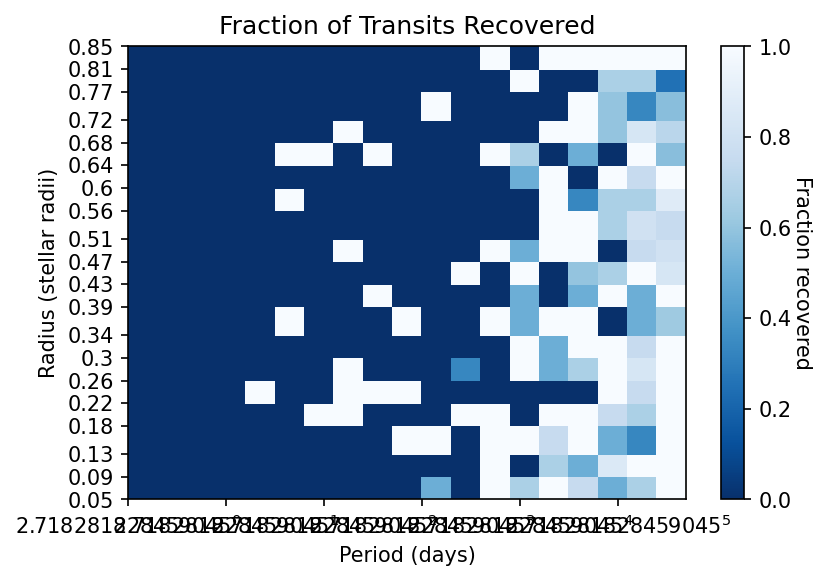

In [46]:
heatmap = plot(recovered_period, recovered_rprs, true_periods, true_rprs, xlog=True)